<a href="https://colab.research.google.com/github/Izel/pollution/blob/master/GRU_LSTM_NO2_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GRU -  LSTM One step univariate model to forecast NO2

In this masters project, we demonstrate how to:

- Prepare time series data for training a RNN forecasting model
- Get data in the required shape for the keras API
- Implement a simple NN model in keras to predict the next step ahead (time *t+1*) in the time series
- Enable early stopping to reduce the likelihood of model overfitting
- Evaluate the model on a test dataset

In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import datetime as dt
import tensorflow as tf
from keras import backend as K
from collections import UserDict
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image
from pandas import read_csv

from keras.models import Model, Sequential
from keras.layers import LSTM, GRU, Dense, Activation
from keras.callbacks import EarlyStopping
from keras.utils import plot_model



# Number formatting
%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)

# Warnings suprising
warnings.filterwarnings("ignore")

Using TensorFlow backend.


## Data preparation

For this preparation, we will set *T=24*. This means that the input for each sample is a vector of the prevous 24 hours of NO2 concentrations. The choice of *T=24* was random but should be selected through experimentation.

*HORIZON=1* specifies that we have a forecasting horizon of 1 (*t+1*)

In [0]:
# History time or previous observations
T = 24
HORIZON = 1

# Number of units in the first hidden layer layer
LATENT_DIM = 20

# Number of samples per mini-batch
BATCH_SIZE = 32 

# Maximum number of times the training will cycle through all samples
EPOCHS = 50

# Function used in the first layer to calculate the values in the neurons
ACTIVATION_1 = 'tanh'

# Function used in the first layer to calculate the values in the output
ACTIVATION_OUT = 'linear'

# Algorith used to minimize the error
OPTIMIZER = 'RMSProp'

## Loading the dataset ##
Loads the dataset from csv file into a Pandas dataframe

In [0]:
# Loads the dataset generated prevously 
def load_data(file_path, plot=True):
  df = read_csv(file_path, sep=',', infer_datetime_format=True, 
                parse_dates=['datetime'], index_col=['datetime'])
  df = df.drop(['month', 'dayofmonth', 'dayofweek'], axis=1)
  
  if(plot):
    df.plot(y='no2', subplots=True, figsize=(20, 8), fontsize=12)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('NO2', fontsize=12)
    plt.show()
  
  return df


# Setting the random seeds to get reproducible values when the model runs again
# with the same configuration values
def reproducible_results (seed_value= 7, plot = True):
  # Setting PYTHONHASHSEED environment variable at a fixed value
  os.environ['PYTHONHASHSEED']=str(seed_value)
  # Set python built-in pseudo-random generator at a fixed value
  random.seed(seed_value)
  # Set numpy pseudo-random generator at a fixed value
  np.random.seed(seed_value)
  # Setting tensorflow pseudo-random generator at a fixed value
  tf.set_random_seed(seed_value)
  # Configuring a new global tensorflow session
  session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
  K.set_session(sess)
  

## Create train, validation and test sets

We separate our dataset into train, validation and test sets. We train the model on the train set. The validation set is used to evaluate the model after each training epoch and ensure that the model is not overfitting the training data. After the model has finished training, we evaluate the model on the test set. We must ensure that the validation set and test set cover a later period in time from the training set, to ensure that the model does not gain from information from future time periods.


We will allocate the period 1st November 2018 to 31st December 2018 to the test set. The period 1st September 2014 to 31st October is allocated to validation set. All other time periods are available for the training set.

In [0]:
def split_data(valid_start_dt, test_start_dt, df, plot):
  df[df.index < valid_start_dt][['no2']].rename(columns={'no2':'train'}) \
      .join(df[(df.index >=valid_start_dt) & (df.index < test_start_dt)][['no2']] \
            .rename(columns={'no2':'validation'}), how='outer') \
      .join(df[test_start_dt:][['no2']].rename(columns={'no2':'test'}),how='outer') \
      .plot(y=['train', 'validation', 'test'], figsize=(20,8), fontsize=12)
    
  if(plot):
    plt.xlabel('year', fontsize=12)
    plt.ylabel('no2', fontsize=12)
    plt.show()
    

### Data preparation - training set
Our data preparation for the training set will involve the following steps:

1. Filter the original dataset to include only that time period reserved for the training set
2. Scale the time series such that the values fall within the interval (0, 1)
3. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
4. Discard any samples with missing values
5. Transform this Pandas dataframe into a numpy array of shape (samples, time steps, features) for input into Keras

In [0]:
def columsIndexes():
  x = []
  index = T-1
  
  for i in range(index,0,-1):
    x.append('load_t-' + str(i))
    
  x.append('load_t')
  return x     
    
 
def prepare_training(df, valid_start_dt, scaler):  
  train = df.copy()[df.index < valid_start_dt][['no2']]
  
  train['no2'] = scaler.fit_transform(train)

  # Shift the dataframe to create the input samples.
  train_shifted = train.copy()
  train_shifted['y_t+1'] = train_shifted['no2'].shift(-1, freq='H')

  for t in range(1, T+1):
      train_shifted[str(T-t)] = train_shifted['no2'].shift(T-t, freq='H')

  y_col = 'y_t+1'
  X_cols = columsIndexes()
  train_shifted.columns = ['load_original'] + [y_col] + X_cols

  # Discard any samples with missing values
  train_shifted = train_shifted.dropna(how='any')
  
  # Transform this Pandas dataframe into a numpy array
  y_train = train_shifted[y_col].as_matrix()
  X_train = train_shifted[X_cols].as_matrix()

  
  # Now convert the target and input features into numpy arrays. 
  # X needs to be in the shape (samples, time steps, features). 
  # Here we have 49607 samples, T time steps and 1 feature (NO2).
  
  X_train = X_train.reshape(X_train.shape[0], T, 1)

  return X_train, y_train

#### Data preparation - validation set

In [0]:
def prepare_validation(df, valid_start_dt, scaler): 
  # Get the validation data from the correct data range
  look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
  valid = df.copy()[(df.index >=look_back_dt) & (df.index < test_start_dt)][['no2']]

  # Scale the series using the transformer fitted on the training set:
  valid['no2'] = scaler.transform(valid)

  # Shift the dataframe to create the input samples
  valid_shifted = valid.copy()
  valid_shifted['y+1'] = valid_shifted['no2'].shift(-1, freq='H')

  for t in range(1, T+1):
      valid_shifted['no2_t-'+str(T-t)] = valid_shifted['no2'].shift(T-t, freq='H')


  # Discard any samples with missing values
  valid_shifted = valid_shifted.dropna(how='any')

  # Transform this Pandas dataframe into a numpy array
  y_valid = valid_shifted['y+1'].as_matrix()
  y_valid = valid_shifted['y+1'].as_matrix()
  X_valid = valid_shifted[['no2_t-'+str(T-t) for t in range(1, T+1)]].as_matrix()
  X_valid = X_valid.reshape(X_valid.shape[0], T, 1)
  
  return X_valid, y_valid


## Implementing the neural models

Thwo models will be implemented, the **LSTM** and the **GRU**.

In [0]:
def lstm_model(X_train,y_train, X_valid, y_valid):
  model = Sequential()
  model.add(LSTM(LATENT_DIM, activation=ACTIVATION_1,input_shape=(T, 1)))
  model.add(Dense(HORIZON,activation=ACTIVATION_OUT))
  model.compile(optimizer=OPTIMIZER, loss='mse')
  # Specify the early stopping criteria. The idea is to monitor the validation loss 
  # (in this case the mean squared error) on the validation set after each 
  # training epoch. If the validation loss has not improved by min_delta after 
  # patience epochs, we stop the training.
  earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=7)
  history = model.fit(X_train,y_train, batch_size=BATCH_SIZE,
                    epochs=EPOCHS, validation_data=(X_valid, y_valid),
                    callbacks=[earlystop], verbose=1)
  # Saving the model
  model.save('./savedModel')
  model.summary()
  #plot_model(model, to_file='LSTM.png')
  return history, model


def gru_model(X_train,y_train, X_valid, y_valid):  
  model = Sequential()
  model.add(GRU(LATENT_DIM, activation=ACTIVATION_1,input_shape=(T, 1)))
  model.add(Dense(HORIZON,activation=ACTIVATION_OUT))
  model.compile(optimizer=OPTIMIZER, loss='mse')

  # Saving the model
  model.save('./savedModel')
  model.summary()
  #plot_model(model, to_file='GRU.png')
  return history, model



## Model Prediction


In [0]:
# Mean of absolute percentage error
def mape(predictions, actuals):
    # Mean absolute percentage error
    return ((predictions - actuals).abs() / actuals).mean()
  
def prediction(model, test_start_dt):
  # 1. Get the test data from the correct data range
  look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
  test = df.copy()[test_start_dt:][['no2']]

  # 2. Scale the data
  test['no2'] = scaler.transform(test)

  # 3. Shift the dataframe to create the input samples
  test_shifted = test.copy()
  test_shifted['y_t+1'] = test_shifted['no2'].shift(-1, freq='H')
  
  for t in range(1, T+1):
    test_shifted['no2_t-'+str(T-t)] = test_shifted['no2'].shift(T-t, freq='H')

  # 4.Discard any samples with missing values
  test_shifted = test_shifted.dropna(how='any')

  # 5.Transform this Pandas dataframe into a numpy array
  y_test = test_shifted['y_t+1'].as_matrix()
  X_test = test_shifted[['no2_t-'+str(T-t) for t in range(1, T+1)]].as_matrix()
  X_test = X_test.reshape(X_test.shape[0], T, 1)
  
  # Making the predictions
  predictions = model.predict(X_test)
  
  eval_df = pd.DataFrame(predictions, columns=[' + ' + str(t) + ' hour(s) Prediction' for t in range(1, HORIZON+1)])
  eval_df['timestamp'] = test_shifted.index
  eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='Model Prediction', var_name='h')
  eval_df['Dataset Value'] = np.transpose(y_test).ravel()
  eval_df[['Model Prediction', 'Dataset Value']] = scaler.inverse_transform(eval_df[['Model Prediction', 'Dataset Value']])  
     
  return eval_df
  

# NO2 forecasting

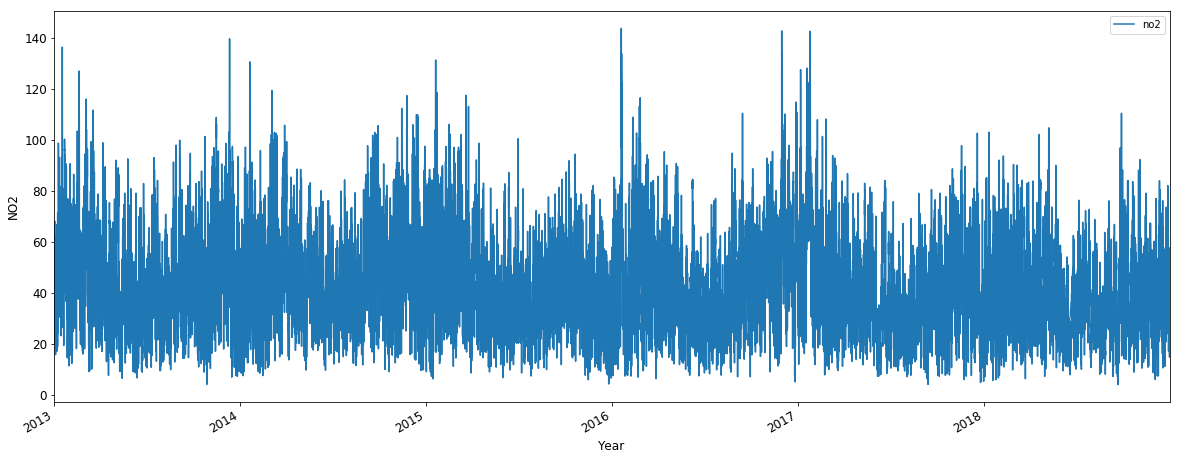

In [9]:

reproducible_results (seed_value= 7, plot = True)

dataset = 'https://raw.githubusercontent.com/Izel/pollution/master/data/no2London-Dataset.csv'
df = load_data(dataset, True)


Defining dates to split the dataset

In [0]:
valid_start_dt = '2018-09-01 00:00:00'
test_start_dt = '2018-11-01 00:00:00'

Splits the datasets according to the dates and obtains the training and validation sets

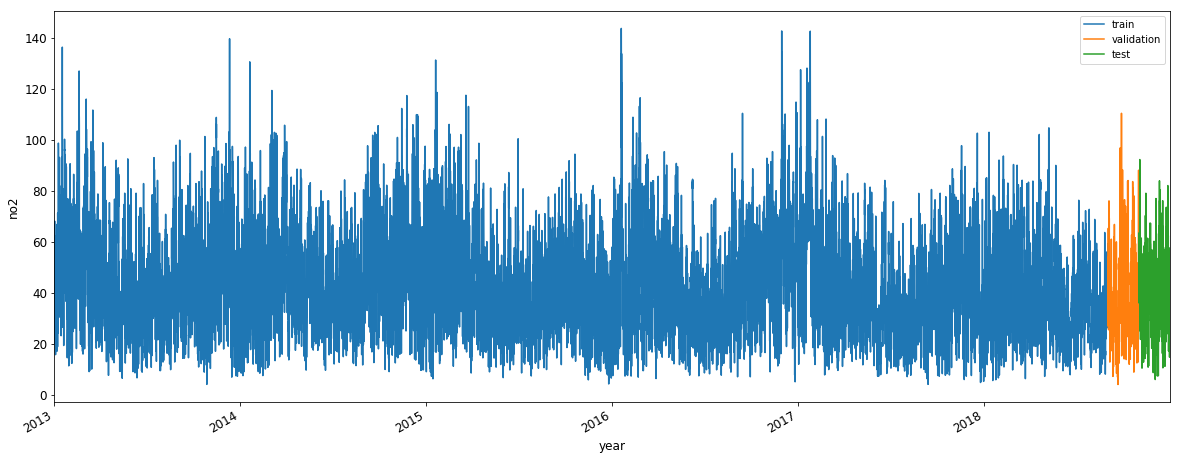

In [11]:
split_data(valid_start_dt, test_start_dt, df, True)

# Scale data to be in range (0, 1). This transformation should be calibrated 
# on the training set only. This is to prevent information from the validation
# or test sets leaking into the training data.
scaler = MinMaxScaler()
  
X_train, y_train = prepare_training(df, valid_start_dt, scaler)
X_valid, y_valid = prepare_validation(df, valid_start_dt, scaler)


Building the model.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 49482 samples, validate on 1463 samples
Epoch 1/50
49482/49482 [==============================] - 21s 424us/step - loss: 0.0029 - val_loss: 0.0012
Epoch 2/50
49482/49482 [==============================] - 20s 399us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 3/50
49482/49482 [==============================] - 20s 398us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 4/50
49482/49482 [==============================] - 19s 393us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 5/50
49482/49482 [==============================] - 20s 410us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 6/50
49482/49482 [==============================] - 19s 388us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 7/50
49482/49482 [==============================] - 20s 397us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 8/50
49482/49482 [==============================] - 21s 425us/step - loss: 0.0010 - val_loss: 0.

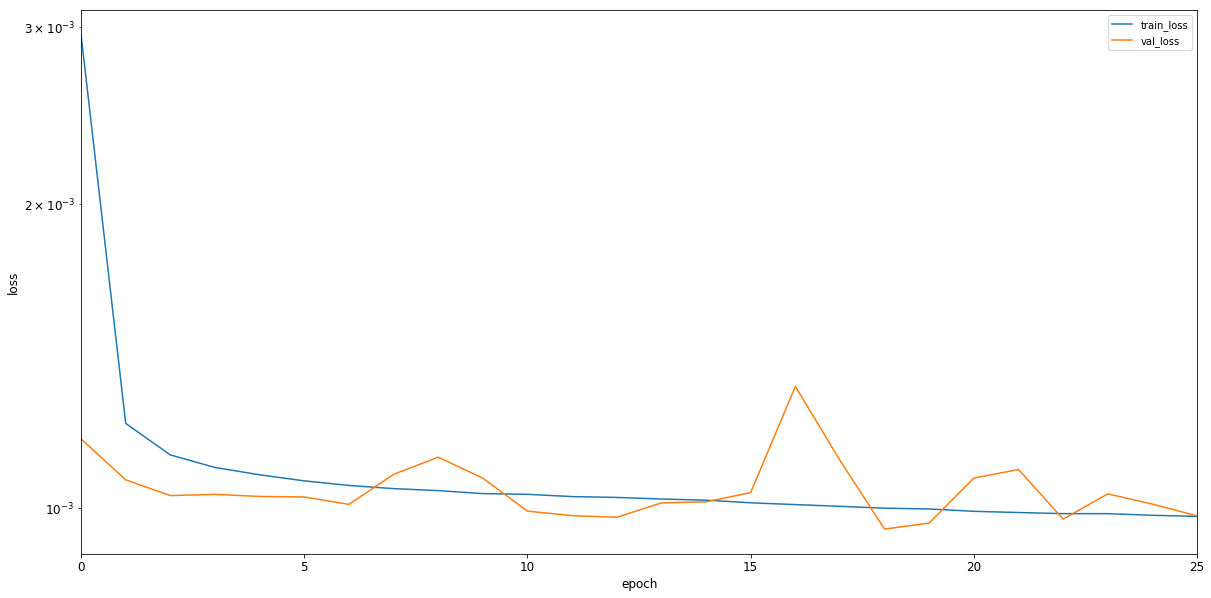

In [12]:
history, model = lstm_model(X_train,y_train, X_valid, y_valid)


# Plotting the model performance
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(20,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()


In [13]:
# Making a prediction and obtaining the error of the model
eval_df = prediction(model, test_start_dt)
eval_df.head(10)

,timestamp,h,Model Prediction,Dataset Value
0,2018-11-01 23:00:00,+ 1 hour(s) Prediction,54.47,52.02
1,2018-11-02 00:00:00,+ 1 hour(s) Prediction,47.57,49.31
2,2018-11-02 01:00:00,+ 1 hour(s) Prediction,46.05,42.74
3,2018-11-02 02:00:00,+ 1 hour(s) Prediction,39.50,41.10
4,2018-11-02 03:00:00,+ 1 hour(s) Prediction,40.13,40.57
5,2018-11-02 04:00:00,+ 1 hour(s) Prediction,42.08,42.75
6,2018-11-02 05:00:00,+ 1 hour(s) Prediction,47.13,49.07
7,2018-11-02 06:00:00,+ 1 hour(s) Prediction,55.27,52.87
8,2018-11-02 07:00:00,+ 1 hour(s) Prediction,55.04,57.86
9,2018-11-02 08:00:00,+ 1 hour(s) Prediction,59.21,59.44


In [14]:
mse = mape(eval_df['Model Prediction'], eval_df['Dataset Value'])
mse


0.0794418291968651

Plots the predictions vs the actuals for the first week of the test set

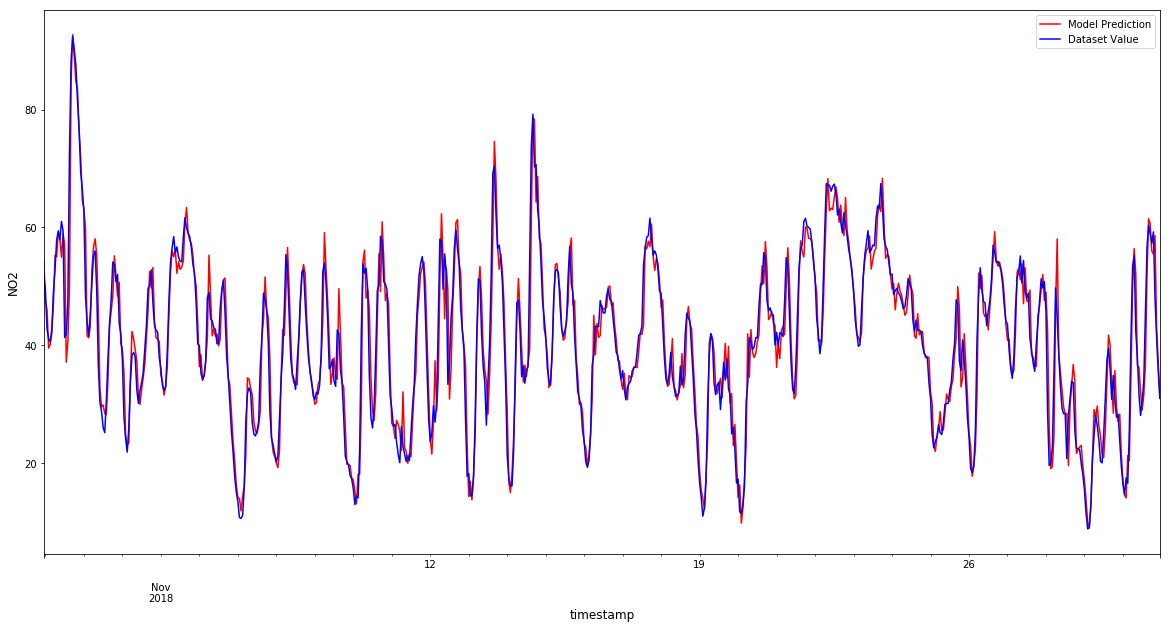

In [15]:
eval_df[eval_df.timestamp<'2018-12-01'].plot(x='timestamp', y=['Model Prediction', 'Dataset Value'], style=['r', 'b'], figsize=(20, 10))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('NO2', fontsize=12)
plt.show()